In [1]:
import os 

import yfinance as yf 
import backtrader as bt 
from datetime import datetime

In [2]:
if not os.path.exists('yfdata'):
    os.mkdir('yfdata')

ticker = 'AMZN'
data = yf.download(ticker, period='1y', interval='1d')
data_path = os.path.join('yfdata', ticker+'.csv')
data.to_csv(data_path)

[*********************100%***********************]  1 of 1 completed


In [3]:
# SMA crossover
# price > SMA --> buy
# price < SMA --> sell
# NO short selling
# holding only 1-share

class SmaStrategy(bt.Strategy):
    params = (('ma_period', 20), )
    
    def __init__(self):
        self.data_close = self.datas[0].close
        self.order = None 
        self.price = None 
        self.comm = None
        self.sma = bt.ind.SMA(self.datas[0], period=self.params.ma_period)
        
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f"{dt} | {txt}")
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return 
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f"BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}")
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f"SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}")
            
            self.bar_executed = len(self)
            
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Failed')
            
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return 
        
        self.log(f"OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}")
        
    def next(self):
        if self.order:
            return
        
        if not self.position:
            if self.data_close[0] > self.sma[0]:
                self.log(f"BUY CREATED --- Price: {self.data_close[0]:.2f}")
                self.order = self.buy()
                
        else:
            if self.data_close[0] < self.sma[0]:
                self.log(f"SELL CREATED --- Price: {self.data_close[0]:.2f}")
                self.order = self.sell()

In [4]:
data = bt.feeds.YahooFinanceCSVData(dataname=data_path)
# data = bt.feeds.YahooFinanceData(dataname='AAPL',fromdate=datetime(2021, 1, 1),todate=datetime(2021, 12, 31))

In [5]:
cerebro = bt.Cerebro(stdstats=False)
cerebro.adddata(data)
cerebro.broker.set_cash(10000)
cerebro.addstrategy(SmaStrategy)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

In [6]:
print(f"Starting Porfolio Value: {cerebro.broker.get_value():.2f}")
cerebro.run()
print(f"Final Porfolio Value: {cerebro.broker.get_value():.2f}")

Starting Porfolio Value: 10000.00
2021-03-22 | BUY CREATED --- Price: 3110.87
2021-03-23 | BUY EXECUTED --- Price: 3127.00, Cost: 3127.00, Commission: 0.00
2021-03-25 | SELL CREATED --- Price: 3046.26
2021-03-26 | SELL EXECUTED --- Price: 3044.06, Cost: 3127.00, Commission: 0.00
2021-03-26 | OPERATION RESULT --- Gross: -82.94, Net: -82.94
2021-03-29 | BUY CREATED --- Price: 3075.73
2021-03-30 | BUY EXECUTED --- Price: 3070.01, Cost: 3070.01, Commission: 0.00
2021-03-30 | SELL CREATED --- Price: 3055.29
2021-03-31 | SELL EXECUTED --- Price: 3064.06, Cost: 3070.01, Commission: 0.00
2021-03-31 | OPERATION RESULT --- Gross: -5.95, Net: -5.95
2021-03-31 | BUY CREATED --- Price: 3094.08
2021-04-01 | BUY EXECUTED --- Price: 3117.94, Cost: 3117.94, Commission: 0.00
2021-05-04 | SELL CREATED --- Price: 3311.87
2021-05-05 | SELL EXECUTED --- Price: 3338.86, Cost: 3117.94, Commission: 0.00
2021-05-05 | OPERATION RESULT --- Gross: 220.92, Net: 220.92
2021-06-02 | BUY CREATED --- Price: 3233.99
202

<IPython.core.display.Javascript object>


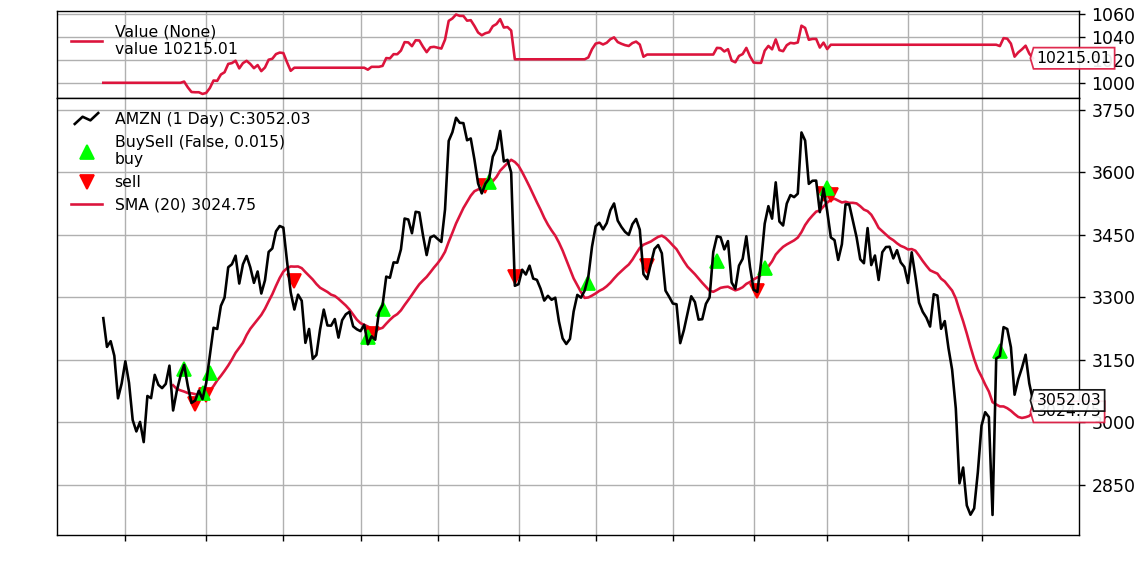

[[<Figure size 640x480 with 2 Axes>]]

In [7]:
cerebro.plot(iplot=True, volume=False)